In [59]:
import sys
sys.path.append('C:/Users/james/OneDrive/바탕 화면/대학교/수업/2024-1/물류관리/Term_project/Modules')

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from utils import *

from savings.link import Link
from savings.node import Node
from savings.graph import Graph
from savings.route import Route
from savings.SavingsModel import SavingsModel

from savings.SavingsAlgorithm import Clarke_Wright_Savings

In [2]:
DEPOT_INDEX = 0 # 창고의 data상 index
DEMAND_CV = 0 # 수요 발생의 변동계수(CV)값 설정
DEMAND_COEFFICIENT = 1 # 수요 발생량에 대해 적절히 곱해주기 위함
ROUTE_TYPE = 'trafast' # route 탐색 방식
JSON_PATH = './../Data/routes_with_depot' # JSON 파일들이 있는 폴더 경로
TRUCK_CAPA = 11560 # 한 트럭이 실을 수 있는 적재 capacity (L)
MAX_TIME = 8 * 60 * 60 * 1000 # ms 단위
SERVICE_TIME = 2*60*1000 # ms 단위

node_data = pd.read_csv('./../Data/data_with_depot.csv')

In [3]:
# 문제 상황에 대한 Graph 객체 만들기
g = Graph()

# Node 등록
for row in node_data.iterrows():
    data = row[1]

    # Node 생성 후 등록
    n = Node(data['index'], data['longitude'], data['latitude'])
    n.generate_demand(data['demand_mu']*DEMAND_COEFFICIENT, data['capacity'], DEMAND_CV)
    g.add_node(n)

# Link 등록
for n1, n2 in tqdm([comb for comb in combinations(g.nodes, 2)]):
    if n1.index > n2.index:
        temp = n2
        n2 = n1
        n1 = temp

    link_cost, link_time = get_cost_time(n1.index, n2.index, ROUTE_TYPE, JSON_PATH, toll_include=True)
    l = Link(n1, n2, link_cost, link_time)
    g.add_link(l)

  0%|          | 0/2145 [00:00<?, ?it/s]

100%|██████████| 2145/2145 [00:13<00:00, 160.91it/s]


In [71]:
# saving 모델 정의 및 돌리기, 알고리즘 2번 돌려보기
svm = SavingsModel(g, DEPOT_INDEX)
svm.calculate_savings()
for s in svm.savings:
    svm.savings[s] += 111821
svm.apply_algorithm([], TRUCK_CAPA, Clarke_Wright_Savings, MAX_TIME, SERVICE_TIME, stochastic_drop=0)
current_route = []
for r in svm.routes:
    x = [n.index for n in r.nodes]
    x.pop(0)
    x.pop(len(x)-1)
    current_route.append(x)
svm.apply_algorithm(current_route, TRUCK_CAPA, Clarke_Wright_Savings, MAX_TIME, SERVICE_TIME, stochastic_drop=0)

svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=True)

for rs in svm.merged_routes:
    for r in rs:
        print(r)
    print('\n')

print(f'최대 적재량 {TRUCK_CAPA:,}L\n운송비 {svm.cost:,}원\n총 수거 {round(svm.demand):,}L')
svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=False)

[[53, 50, 12, 8, 41, 47, 40, 48, 17, 37, 10, 52], [18, 28, 38], [31, 45, 1, 15, 14, 19, 23, 42, 54, 32, 39, 22, 29, 30, 20, 27, 25], [11, 6, 9, 16, 44, 2], [4, 5, 3], [13, 33, 24, 26, 43, 49], [46, 7, 51], [59, 64, 61, 65, 58, 55, 57, 60, 63, 62, 56], [35, 21, 36, 34]]
Route : 0 - 53 - 50 - 12 - 8 - 41 - 47 - 40 - 48 - 17 - 37 - 10 - 52 - 0
Demand met : 686.5508541700001, Cost : 28183, Time 5H 5M


Route : 0 - 31 - 45 - 1 - 15 - 14 - 19 - 23 - 42 - 54 - 32 - 39 - 22 - 29 - 30 - 20 - 27 - 25 - 0
Demand met : 907.137935241, Cost : 24895, Time 4H 54M
Route : 0 - 11 - 6 - 9 - 16 - 44 - 2 - 0
Demand met : 370.598431744, Cost : 18946, Time 2H 38M


Route : 0 - 18 - 28 - 38 - 0
Demand met : 214.12342718, Cost : 34230, Time 3H 52M
Route : 0 - 13 - 33 - 24 - 26 - 43 - 49 - 0
Demand met : 305.83233445, Cost : 14428, Time 2H 16M
Route : 0 - 46 - 7 - 51 - 0
Demand met : 22.510921447999998, Cost : 12210, Time 1H 42M


Route : 0 - 4 - 5 - 3 - 0
Demand met : 151.75062185000002, Cost : 15076, Time 1H 

201617475

In [70]:
print(Route(g, [0, 59, 64, 61, 65, 58, 55, 57, 60, 63, 62, 56, 35, 21, 36, 34, 0]))

Route : 0 - 59 - 64 - 61 - 65 - 58 - 55 - 57 - 60 - 63 - 62 - 56 - 35 - 21 - 36 - 34 - 0
Demand met : 2259.020892784, Cost : 16120, Time 4H 21M


In [5]:
# saving 모델 정의 및 돌리기
svm = SavingsModel(g, DEPOT_INDEX)
svm.calculate_savings()
for s in svm.savings:
    svm.savings[s] += 111821
svm.apply_algorithm([], TRUCK_CAPA, Clarke_Wright_Savings, MAX_TIME, SERVICE_TIME, stochastic_drop=0)


print('[Clarke_Wright_Saving의 Cost]')
lowest = svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=False)
lowest_svm = None

for i in tqdm(range(100)):
    stochastic_svm = SavingsModel(g, DEPOT_INDEX)
    stochastic_svm.calculate_savings()
    for s in svm.savings:
        svm.savings[s] += 111821
    stochastic_svm.apply_algorithm([], TRUCK_CAPA, Clarke_Wright_Savings, MAX_TIME, SERVICE_TIME, stochastic_drop=0.1)

    sto_cost = stochastic_svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=True)
    if lowest > sto_cost:
        lowest = sto_cost
        lowest_svm = stochastic_svm
        print('better solution found')
        print(f'Better Cost : {sto_cost:,}')

print('\n[Total Saved from stochastic C&W method]')
print(f'{svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=True)-lowest:,}원')

[Clarke_Wright_Saving의 Cost]
연간 운송비: 61,617,475원
연간 인건비: 140,000,000원
연간 총 비용: 201,617,475원


 38%|███▊      | 38/100 [01:00<00:57,  1.08it/s]

better solution found
Better Cost : 201,443,370


 60%|██████    | 60/100 [01:49<00:46,  1.17s/it]

better solution found
Better Cost : 196,865,905


100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


[Total Saved from stochastic C&W method]
4,751,570원


In [53]:
for rs in lowest_svm.merged_routes:
    for r in rs:
        print(r)
    print('\n')

print(f'최대 적재량 {TRUCK_CAPA:,}L\n운송비 {lowest_svm.cost:,}원\n총 수거 {round(lowest_svm.demand):,}L')
lowest_svm.yearly_cost(MAX_TIME, fixed=int(35000000), verbose=False)

Route : 0 - 53 - 50 - 12 - 8 - 41 - 47 - 40 - 48 - 17 - 37 - 10 - 52 - 0
Demand met : 686.5508541700001, Cost : 28183, Time 5H 5M


Route : 0 - 31 - 43 - 26 - 27 - 20 - 30 - 1 - 14 - 15 - 19 - 23 - 42 - 54 - 32 - 39 - 22 - 29 - 45 - 24 - 33 - 49 - 13 - 0
Demand met : 1021.786974891, Cost : 26089, Time 5H 26M


Route : 0 - 18 - 28 - 38 - 0
Demand met : 214.12342718, Cost : 34230, Time 3H 52M
Route : 0 - 3 - 4 - 5 - 25 - 0
Demand met : 342.93391665, Cost : 15158, Time 2H 5M
Route : 0 - 46 - 7 - 51 - 0
Demand met : 22.510921447999998, Cost : 12210, Time 1H 42M


Route : 0 - 2 - 11 - 6 - 9 - 16 - 44 - 0
Demand met : 370.598431744, Cost : 19059, Time 2H 40M
Route : 0 - 59 - 64 - 61 - 65 - 58 - 55 - 57 - 60 - 63 - 62 - 56 - 0
Demand met : 2242.0504826, Cost : 11492, Time 3H 41M
Route : 0 - 21 - 36 - 34 - 35 - 0
Demand met : 16.970410184, Cost : 9376, Time 1H 28M


최대 적재량 11,560L
운송비 155,797원
총 수거 4,918L
연간 운송비: 56,865,905원
연간 인건비: 140,000,000원
연간 총 비용: 196,865,905원


196865905

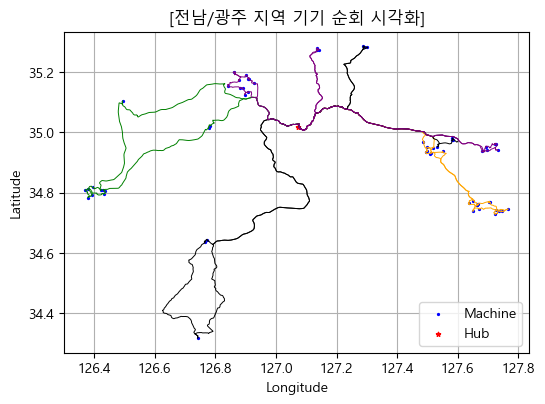

In [56]:
# figsize 비율 계산
ratio = (node_data.latitude.max() - node_data.latitude.min()) / (node_data.longitude.max() - node_data.longitude.min())
scale = 6

# fig, ax 객체 생성
fig, ax = plt.subplots(figsize=(scale, scale * ratio))

# 차량의 color 팔레트 지정
color_pallete = ['green', 'orange', 'black', 'purple', 'olive', 'gray', 'skyblue', 'green', 'orange', 'black', 'purple', 'olive', 'gray', 'skyblue']

# 데이터 플롯
ax.scatter(node_data['longitude'], node_data['latitude'], s=1.8, c='blue', label='Machine')
ax.scatter(lowest_svm.depot.x, lowest_svm.depot.y, s=10, c='red', label='Hub', marker='*')

# 축 레이블, 제목 및 범례 설정
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('[전남/광주 지역 기기 순회 시각화]', fontsize=12)
ax.grid()

# 그래프를 보여줍니다.
ax.legend(loc='lower right')

# 각 route를 visualize
for i, m_routes in enumerate(lowest_svm.merged_routes):
    for route in m_routes:
        x = input('next')
        route.visualize(ax, JSON_PATH, route_option='trafast', update_sec = 0.05, color = color_pallete[i])